In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [3]:
exps = dict()
for exp in range(5):
    exps[exp] = dict()

In [5]:
exps[0]['path'] = '/myvol/data2/20190831/20180831_L10C.h5ad'
exps[1]['path'] = '/myvol/data2/20190831/20180831_L20C1.h5ad'
exps[2]['path'] = '/myvol/data2/20190831/20180831_L20T.h5ad'
exps[3]['path'] = '/myvol/data2/20190831/20180831_L30C.h5ad'
exps[4]['path'] = '/myvol/data2/20190831/20180831_L30C8.h5ad'

In [6]:
for exp in exps:
    exps[exp]['adata'] = sc.read_h5ad(exps[exp]['path'])

In [7]:
for exp in exps:
    exps[exp]['label'] = exps[exp]['path'].split('/')[-1]

In [14]:
adata = exps[0]['adata'].concatenate([exps[exp]['adata'] for exp in range(1,5)],
                                           batch_categories=
                                           [exps[exp]['label'] for exp in range(5)]).copy()

In [15]:
human_genes = [i for i in exps[0]['adata'].var_names if i.startswith('hg19_')]
mouse_genes = [i for i in exps[0]['adata'].var_names if i.startswith('mm10_')]

Extract out separate adatas for each genome, and extract out UMIs as "n_counts" in obs (per cell) and in the vars (per gene).

In [16]:
adata_human = adata[:,human_genes].copy()
adata_human.var_names = [i[5:] for i in adata_human.var_names] # no need for the genome tag at the beginning anymore
adata_mouse = adata[:,mouse_genes].copy()
adata_mouse.var_names = [i[5:] for i in adata_mouse.var_names]

In [17]:
human_min_counts = 1e3
human_min_genes = 5e2

mouse_min_counts = 30
mouse_min_genes = 15

In [18]:
adata.obs['human_cells_counts_bool'] = sc.pp.filter_cells(adata_human,min_counts=human_min_counts,inplace=False)[0]
adata.obs['human_cells_counts_vals'] = sc.pp.filter_cells(adata_human,min_counts=human_min_counts,inplace=False)[1]

adata.obs['human_cells_genes_bool'] = sc.pp.filter_cells(adata_human,min_counts=human_min_genes,inplace=False)[0]
adata.obs['human_cells_genes_vals'] = sc.pp.filter_cells(adata_human,min_counts=human_min_genes,inplace=False)[1]

adata.obs['mouse_cells_counts_bool'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_counts,inplace=False)[0]
adata.obs['mouse_cells_counts_vals'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_counts,inplace=False)[1]

adata.obs['mouse_cells_genes_bool'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_genes,inplace=False)[0]
adata.obs['mouse_cells_genes_vals'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_genes,inplace=False)[1]

filtered out 43869 cells that haveless than 1000.0 counts
filtered out 43869 cells that haveless than 1000.0 counts
filtered out 43127 cells that haveless than 500.0 counts
filtered out 43127 cells that haveless than 500.0 counts
filtered out 3233 cells that haveless than 30 counts
filtered out 3233 cells that haveless than 30 counts
filtered out 2236 cells that haveless than 15 counts
filtered out 2236 cells that haveless than 15 counts


In [19]:
human = (adata.obs['human_cells_counts_bool'] == True) & (adata.obs['human_cells_genes_bool'] == True) & \
(adata.obs['mouse_cells_counts_bool'] == False) & (adata.obs['mouse_cells_genes_bool'] == False)

mouse = (adata.obs['mouse_cells_counts_bool'] == True) & (adata.obs['mouse_cells_genes_bool'] == True) & \
(adata.obs['human_cells_counts_bool'] == False) & (adata.obs['human_cells_genes_bool'] == False)

In [20]:
columns = adata.obs.columns.tolist()
adata_human = adata_human[human].copy()
adata_human.obs[columns] = adata.obs.loc[human,columns]
adata_mouse = adata_mouse[mouse].copy()
adata_mouse.obs[columns] = adata.obs.loc[mouse,columns]

In [22]:
with open('/myvol/data2/concat3.keepcells.txt','r') as file:
    keepcells = [i.strip() for i in file.readlines()]

In [23]:
adata_mouse = adata_mouse[keepcells].copy()

In [24]:
sc.pp.filter_genes(adata_mouse,min_counts=60)
sc.pp.filter_genes(adata_mouse,min_cells=60)

filtered out 42877 genes that are detectedin less than 60 counts
filtered out 1579 genes that are detectedin less than 60 cells


In [25]:
genelist = adata_mouse.var_names.tolist()

mito_genes_names_mouse = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes_mouse = [genelist.index(gn) for gn in mito_genes_names_mouse]

ribo_genes_names_mouse = [gn for gn in genelist if gn.startswith('Rps') or gn.startswith('Rpl')]
ribo_genes_mouse = [genelist.index(gn) for gn in ribo_genes_names_mouse]

In [26]:
adata_mouse.obs['percent_mito_mouse'] = np.ravel(np.sum(adata_mouse[:, mito_genes_mouse].X, axis=1)) / np.ravel(np.sum(adata_mouse.X, axis=1))
adata_mouse.obs['percent_ribo_mouse'] = np.ravel(np.sum(adata_mouse[:, ribo_genes_mouse].X, axis=1)) / np.ravel(np.sum(adata_mouse.X, axis=1))

In [27]:
def process1(adata):
    sc.pp.log1p(adata)
    sc.pp.normalize_per_cell(adata)
    return adata

In [28]:
adata_mouse = process1(adata_mouse)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [29]:
def process2_check(adata,min_mean=0.0125, min_disp=0.5):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor='cell_ranger',inplace=True, min_mean=min_mean, min_disp=min_disp, n_bins=100)
    print(sum(hv_adata.var['highly_variable'].values))
    sc.pl.highly_variable_genes(hv_adata,log=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
1072


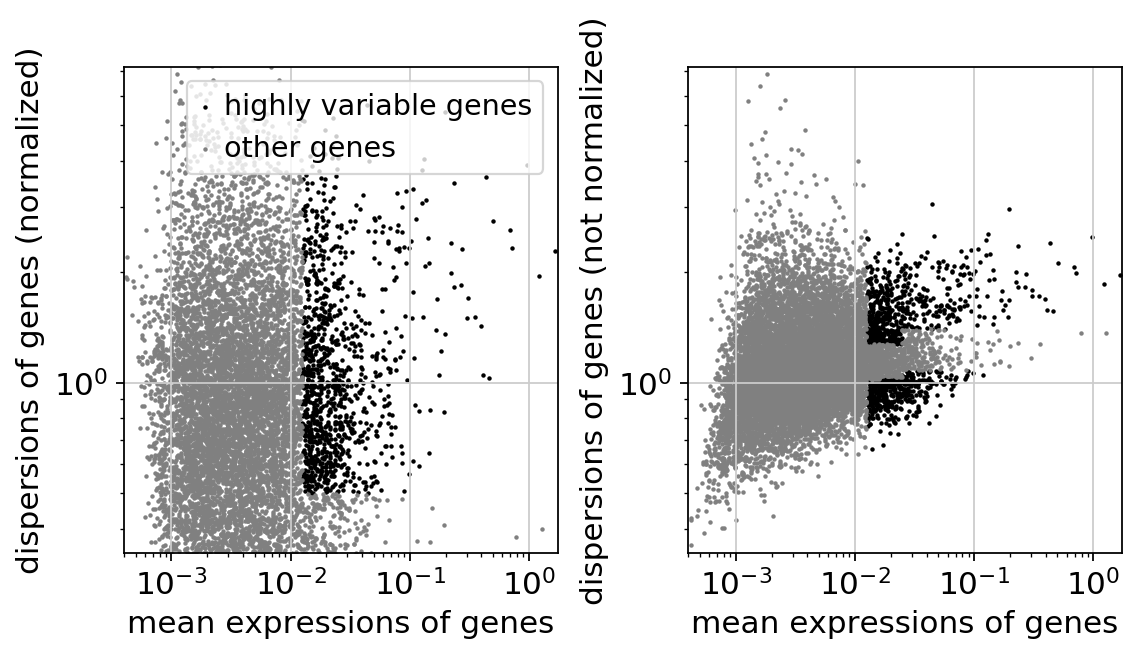

In [30]:
process2_check(adata_mouse)

In [31]:
my_min_mean = 0.001
my_min_disp = 0.7

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
5296


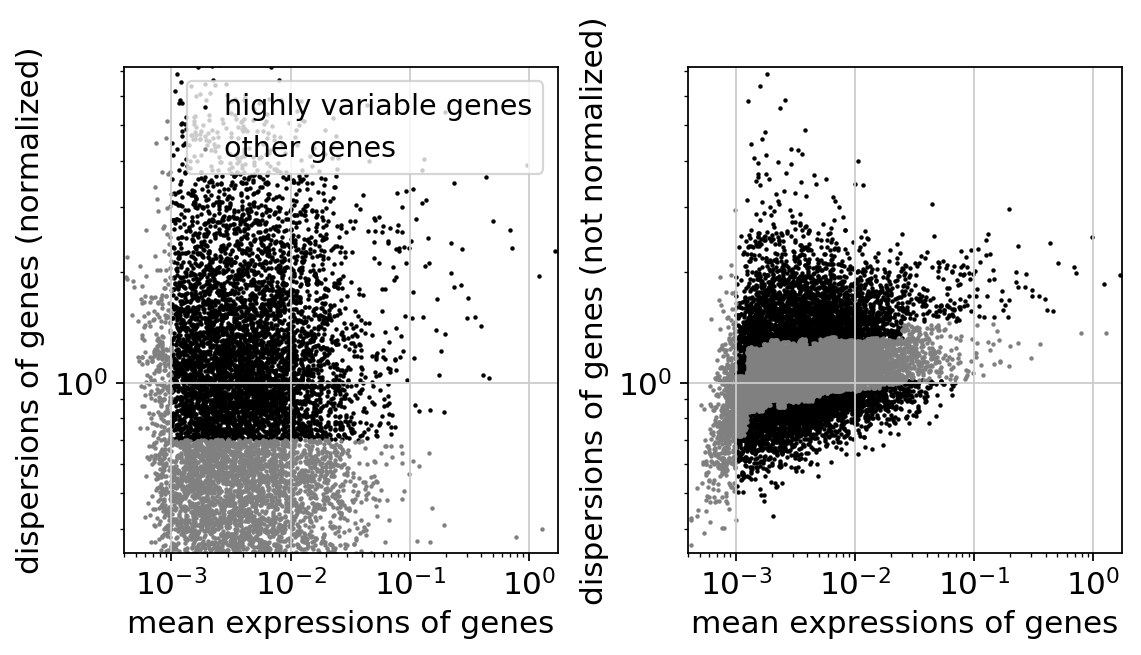

In [32]:
process2_check(adata_mouse, min_mean=my_min_mean, min_disp=my_min_disp)

In [33]:
def process2(adata, min_mean, min_disp):    # Extract out highly variable genes, but don't subset just yet.
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger',inplace=True, subset=True, min_mean=min_mean, min_disp=min_disp, n_bins=100)

In [34]:
process2(adata_mouse,min_mean=my_min_mean, min_disp=my_min_disp)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [35]:
# adata_mouse.write('/myvol/data2/my.h5ad')

In [4]:
adata_mouse = sc.read_h5ad('/myvol/data2/my.h5ad')

In [5]:
warnings.filterwarnings('ignore')
sc.pp.combat(adata_mouse, covariates=['percent_mito_mouse','n_counts','human_cells_counts_vals'])
warnings.filterwarnings('default')

Standardizing Data across genes.

Found 5 batches

Found 3 numerical variables:
	percent_mito_mouse, n_counts, human_cells_counts_vals

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [6]:
sc.pp.scale(adata_mouse, max_value=10)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


    finished (0:00:05)


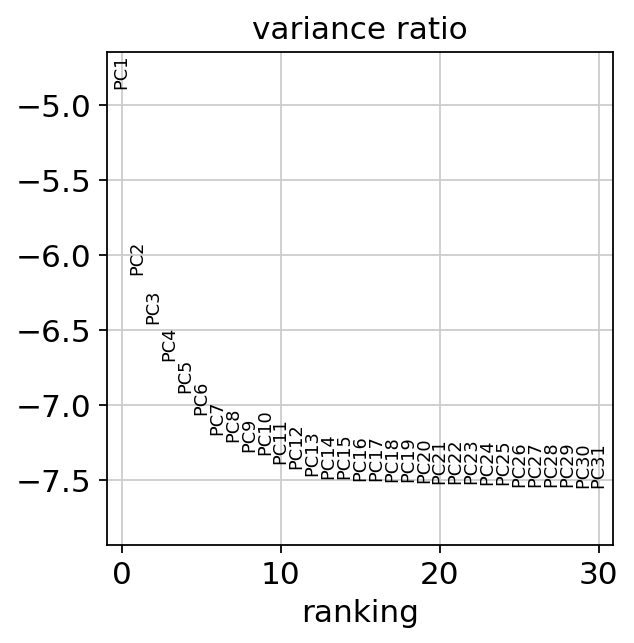

In [7]:
sc.pp.pca(adata_mouse)
sc.pl.pca_variance_ratio(adata_mouse,log=True)

In [8]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(adata_mouse,n_neighbors=15,n_pcs=13) #12 # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 13
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:12)


In [9]:
sc.tl.leiden(adata_mouse,resolution=0.8)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:29)


In [10]:
warnings.filterwarnings('ignore')
sc.tl.umap(adata_mouse, spread=5, alpha=2) # runtime warning I think is ok
warnings.filterwarnings('default')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)


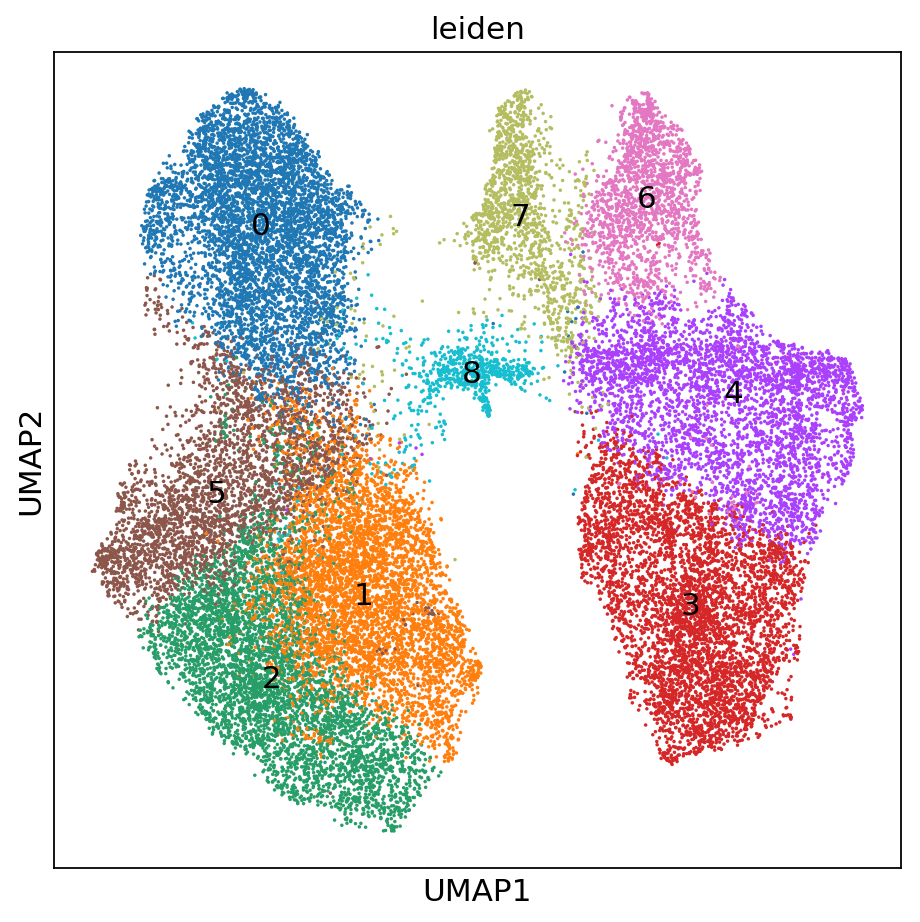

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.umap(adata_mouse,color='leiden',ax=ax, legend_loc='on data', return_fig=False, show=False, size=10, legend_fontweight='normal')
plt.tight_layout()

In [18]:
adata_mouse.obs['batch'] = [i.split('_')[1].split('.')[0] for i in adata_mouse.obs['batch']]

In [19]:
adata_mouse.obs['batch'].unique()

array(['L10C', 'L20C1', 'L20T', 'L30C', 'L30C8'], dtype=object)

In [20]:
# scanpy's stupid sort order doesn't work with categorical variables, need to make a separate covariate with a "continuous" binary scale
for batch in adata_mouse.obs['batch'].unique():
    adata_mouse.obs['batch%s' % batch] = (adata_mouse.obs['batch'] == batch).astype(int)

... storing 'batch' as categorical


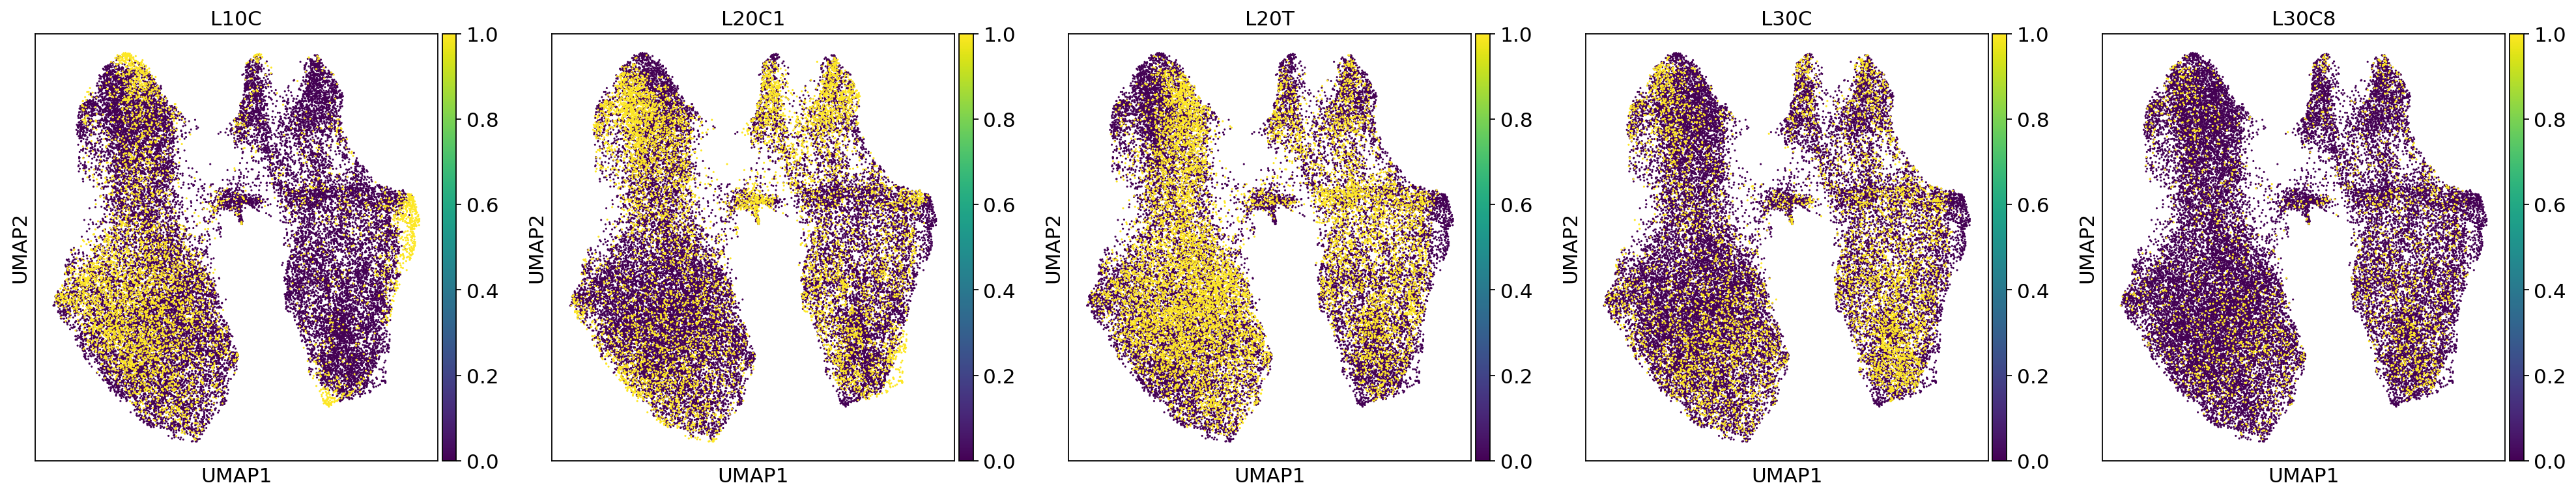

In [21]:
colorby = adata_mouse.obs['batch'].unique()
numplots = len(colorby)
fig, axes = plt.subplots(1,numplots,figsize=(25,25/numplots))
for group, ax in zip(colorby,np.ravel(axes)):
    sc.pl.umap(adata_mouse,color='batch%s' % str(group), sort_order=True, title=str(group), 
               ax=ax, return_fig=False, show=False, legend_loc=None, size=8, palette=['red'])
plt.tight_layout()

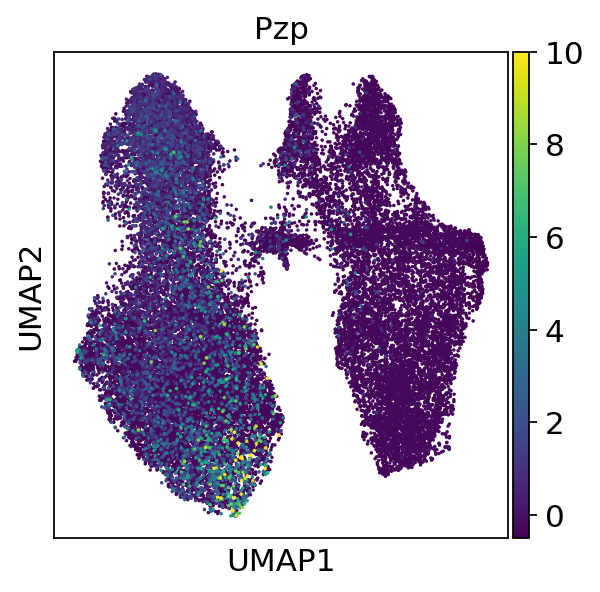

<Figure size 320x320 with 0 Axes>

In [52]:
# fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.umap(adata_mouse,color=['Pzp'], size=10, legend_fontweight='normal')
plt.tight_layout()

In [38]:
ctdict = dict()
ctdict['MC38'] = [3, 4]
ctdict['Lymphocyte'] = [6]
ctdict['Kupffer'] = [7]
ctdict['LSEC'] = [8]
ctdict['Hepato1'] = [5]
ctdict['Hepato2'] = [1, 2]
ctdict['Hepato3'] = [0]
adata_mouse.obs['celltype'] = adata_mouse.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        adata_mouse.obs['celltype'].replace(r'^%s$' % str(clust),ct,regex=True, inplace=True)
adata_mouse.obs['celltype'] = adata_mouse.obs['celltype'].astype('category')

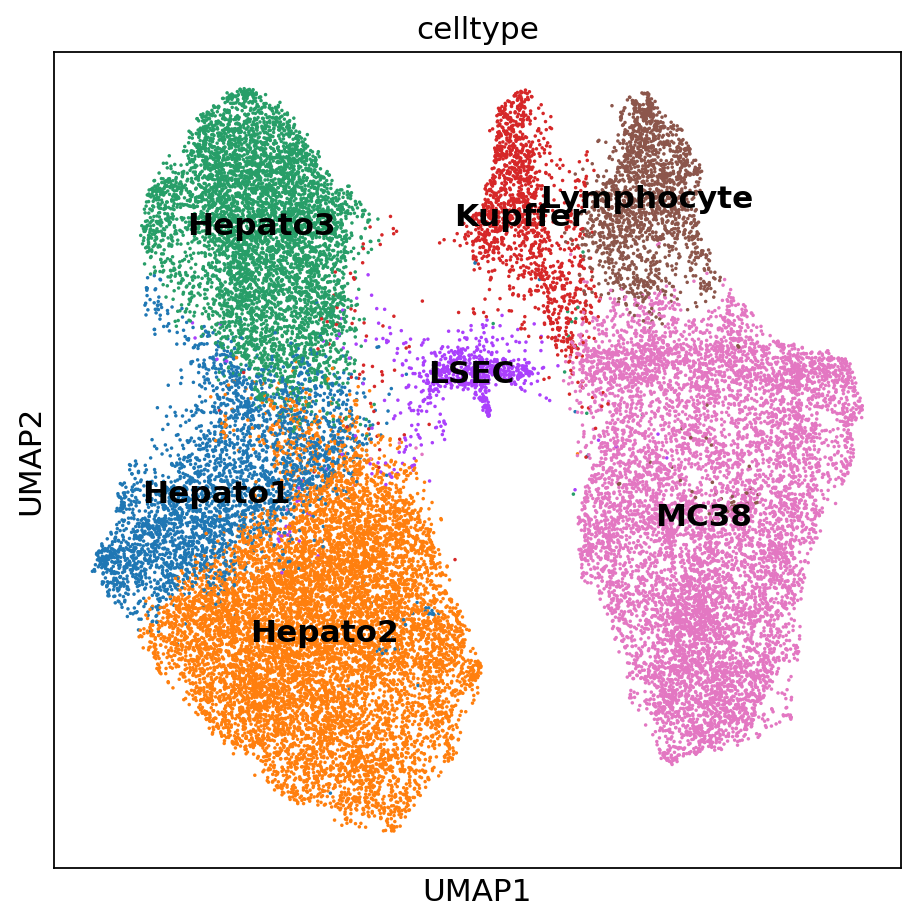

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.umap(adata_mouse,color='celltype',ax=ax, legend_loc='on data', return_fig=False, show=False, size=10)
plt.tight_layout()
plt.savefig('/myvol/data2/concat4.umap.svg',dpi=300, format='svg')

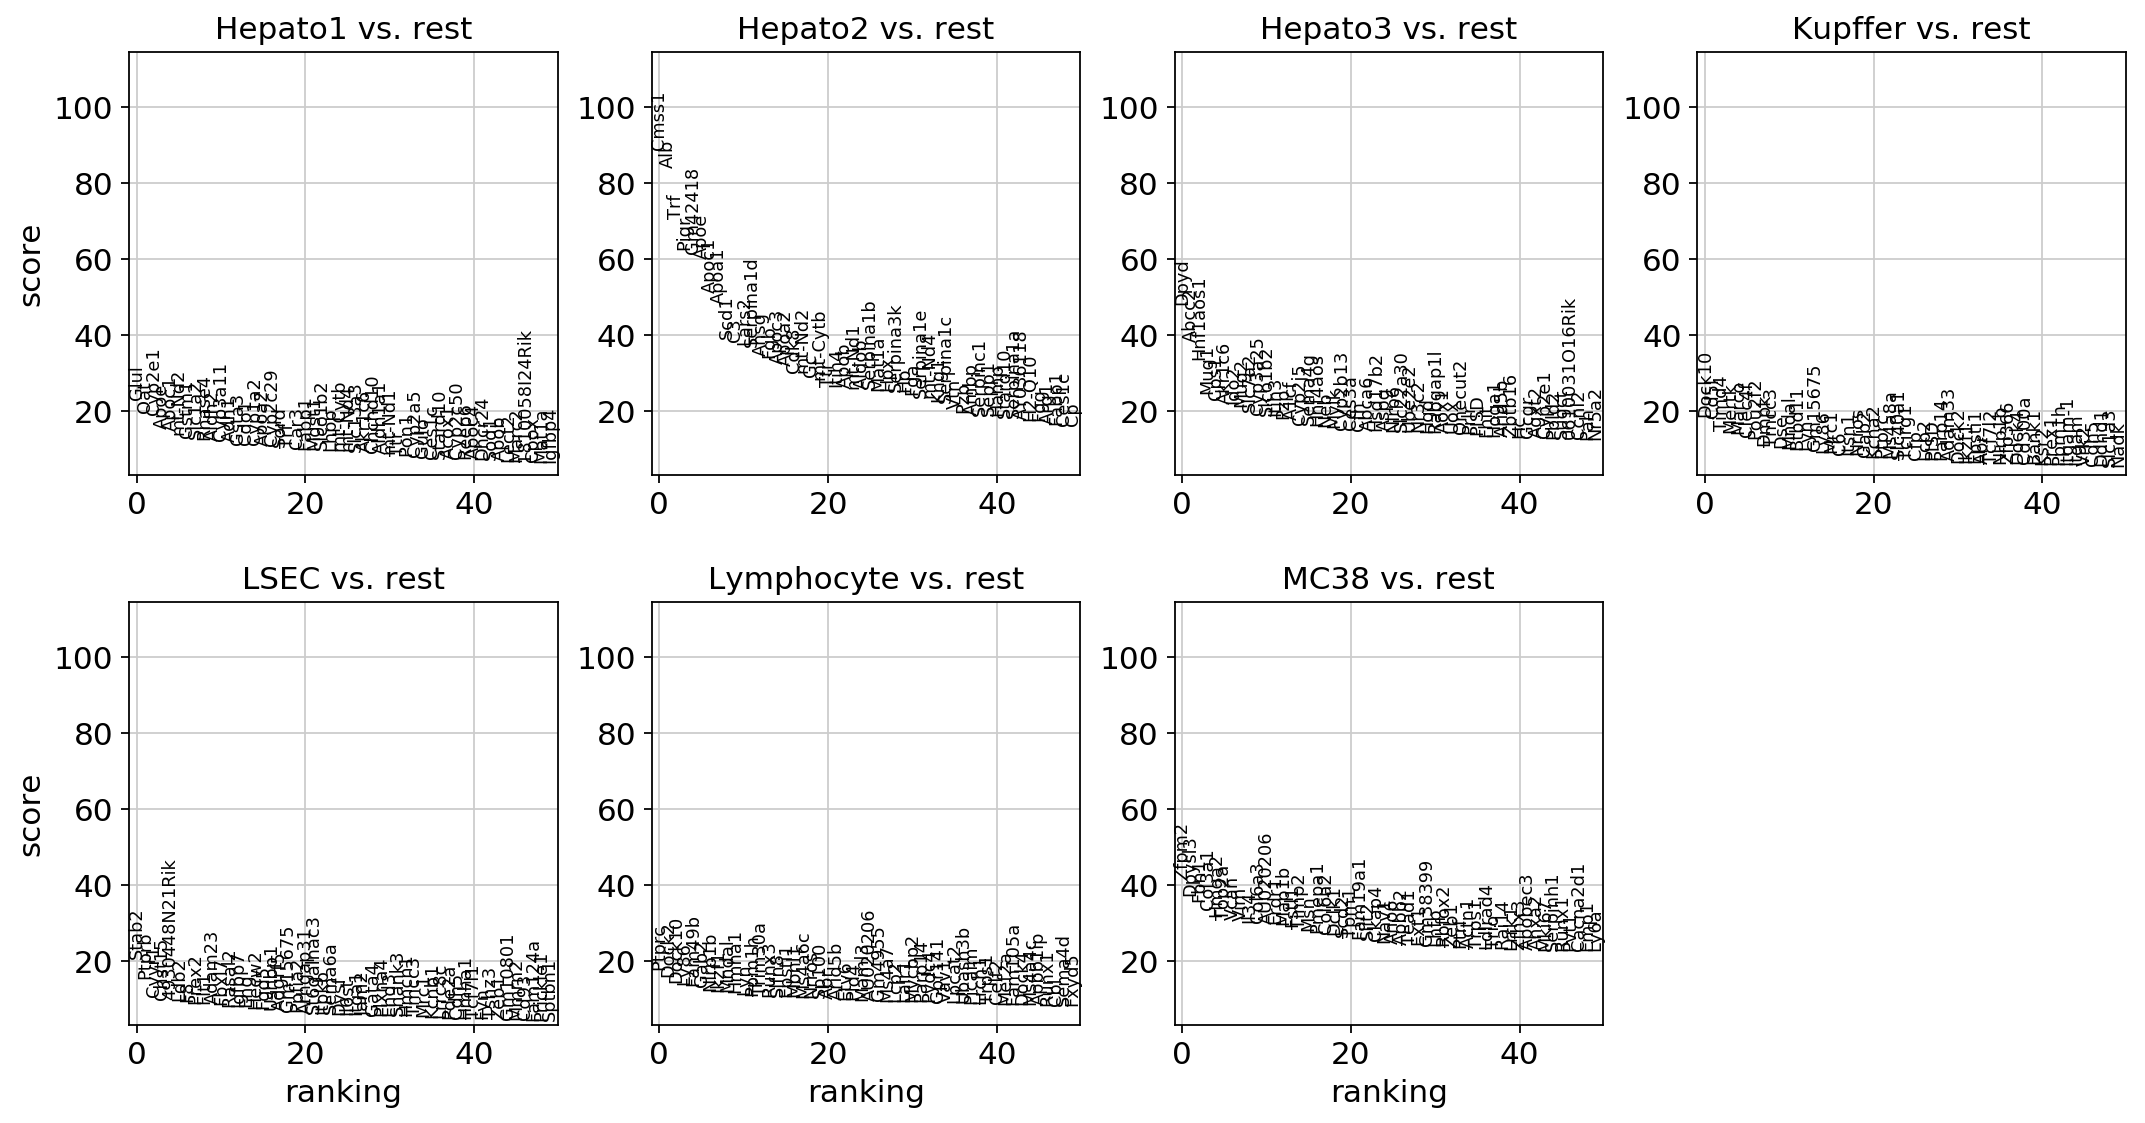

In [40]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata_mouse,use_raw=False,groupby='celltype')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(adata_mouse,n_genes=50)
sc.settings.verbosity = 3

## Make Bubble Plot

Define the genes we want to look at in the bubble plot.

In [41]:
genes = ['Stab2', 'Ptprb', 'Cyyr1', 'Zfpm2','Dpysl3','Fbn1', 'Glul','Oat',
         'Cyp2e1', 'Apoe', 'Apoc1', 'Apoa2', 'Alb','Trf','Pigr','Dpyd',
         'Abcc2','Hnf1aos1','Dock10','Cd5l','Timd4','Marco','Ptprc', 'Dock2',
         'Fam49b','Sema4d','Hmha1','Ms4a6c','Ms4a4c']

Define the cell types.

In [42]:
cts = ['Hepato1','Hepato2','Hepato3','LSEC','Kupffer','Lymphocyte','MC38']

Generate two DataFrames, one with the percentage of cells expressing per cell type, and the other with the mean expression of the gene for each cell type.

In [43]:
percentdf = pd.DataFrame(np.zeros((len(cts),len(genes))),index=cts,columns=genes)
expdf = pd.DataFrame(np.zeros((len(cts),len(genes))),index=cts,columns=genes)

Generate a thresholds dictionary. This is the threshold at which I define a cluster expressing the gene. Because the genes are scaled and centered at zero, its usally around zero but for the purposes of the plot, I manually gate them to be sure.

In [44]:
# thresholds = dict() # commented out because I didn't want to risk re-running it and have to redo the gating.

Plot the genes and capture a threshold.

In [ ]:
for gene in genes:
    plt.figure(figsize=(15,4))
    print(gene)
    plt.hist(adata_mouse.obs_vector(gene),bins=200);
    plt.yscale('log')
    plt.show()
    thresholds[gene] = float(input())

Fill in the DataFrames I instantiated.

In [283]:
for gene in tqdm(genes):
    for ct in cts:
        vals = adata_mouse[adata_mouse.obs['celltype'] == ct].copy().obs_vector(gene)
        percentdf.loc[ct,gene] = sum(vals > thresholds[gene])/len(vals)
        expdf.loc[ct,gene] = vals.mean()

Normalize the expression DataFrame in order to 1. mute the expression level for those cell types that have one below the manually defined thresholds, since this is likely just capturing noise, and 2. normalize to the expression level of the most-highly expressing cell type.

In [274]:
expdf_norm = expdf.copy()

In [296]:
for gene in expdf_norm:
    genemin = expdf_norm[gene].min()
    expdf_norm[gene] = expdf_norm[gene] - genemin # shift such that the min is zero
    expdf_norm[gene] = np.where(expdf_norm[gene].values > (thresholds[gene] + genemin), expdf_norm[gene].values, 0) # replace anything below zero with zero
expdf_norm = expdf_norm.div(expdf_norm.sum(axis=0), axis=1)

Plot it.

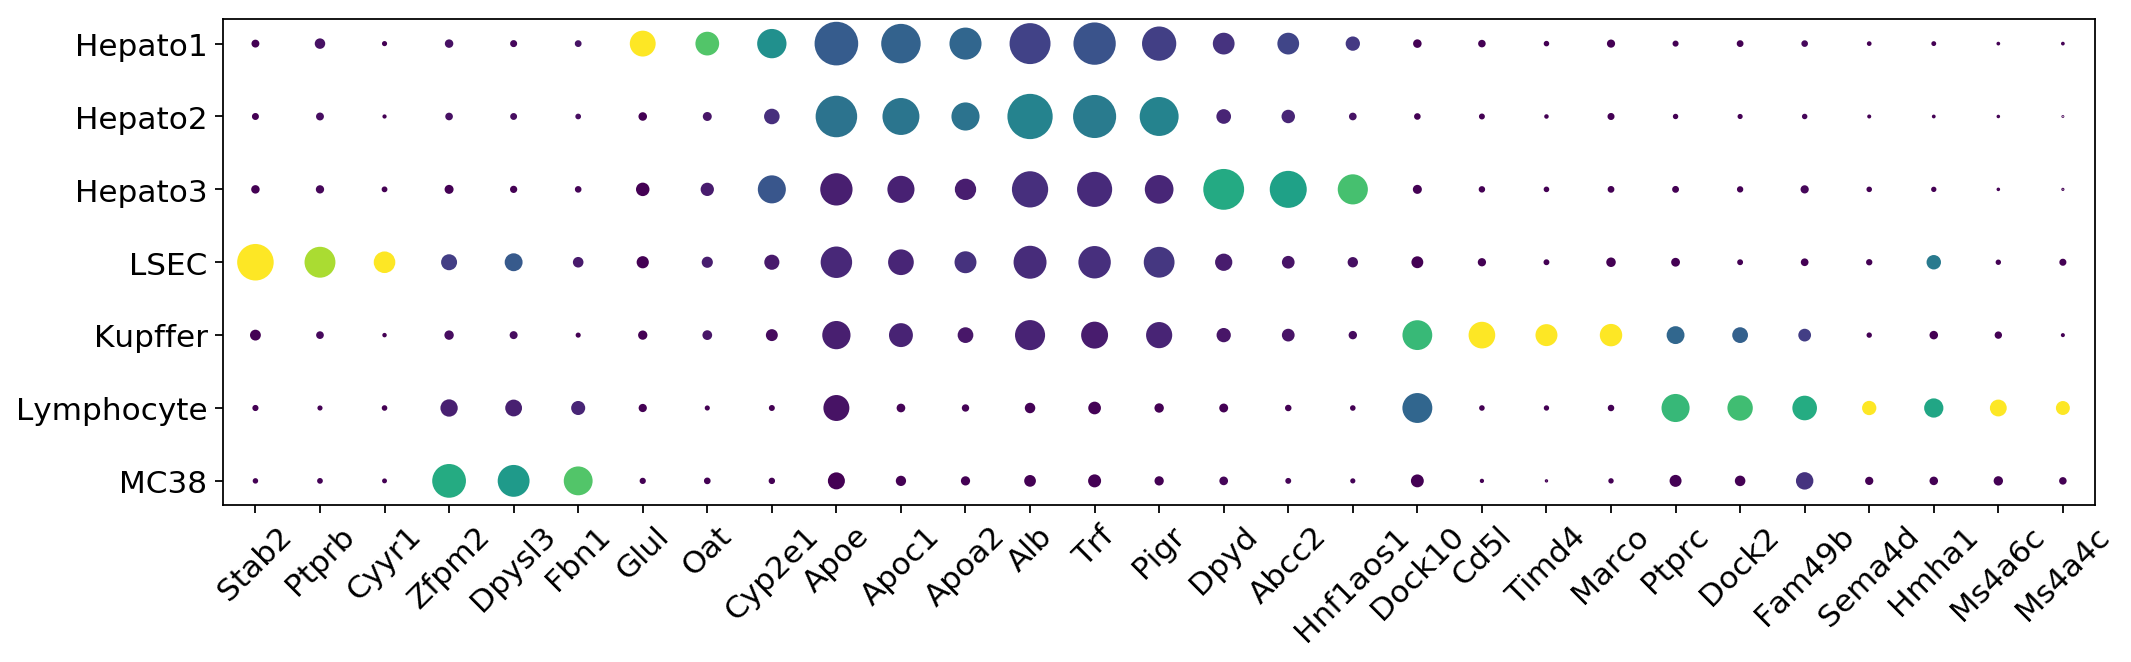

In [318]:
plt.figure(figsize=(15,4))
plt.scatter([i[::-1][0] for i in it.product(range(len(cts))[::-1], 
                                            range(len(genes)))], 
            [i[::-1][1] for i in it.product(range(len(cts))[::-1], 
                                            range(len(genes)))], 
            s=500*np.ravel(percentdf.values), 
            c=np.ravel(expdf_norm.values));
plt.xticks(range(len(genes)),labels=genes, rotation=45)
plt.yticks(range(len(cts)),labels=cts[::-1])
plt.xlim(-0.5,28.5)
plt.grid(False)
# plt.show()
plt.savefig('/myvol/data2/concat4.shallow.bubble.svg',dpi=300, format='svg')

Going to export to see if I can do superresolution.

In [6]:
# sc.write('/myvol/data2/concat4.adata_mouse.h5ad', adata_mouse)
adata_mouse = sc.read_h5ad('/myvol/data2/concat4.adata_mouse.h5ad')

Sent the `.obs` to Derek so he could plot them on the spatial map, but this was with the earlier iteration.

In [61]:
# adata_mouse.obs.to_csv('/myvol/data2/data/covars.derek.csv')

## Define Gene Sets for Registration

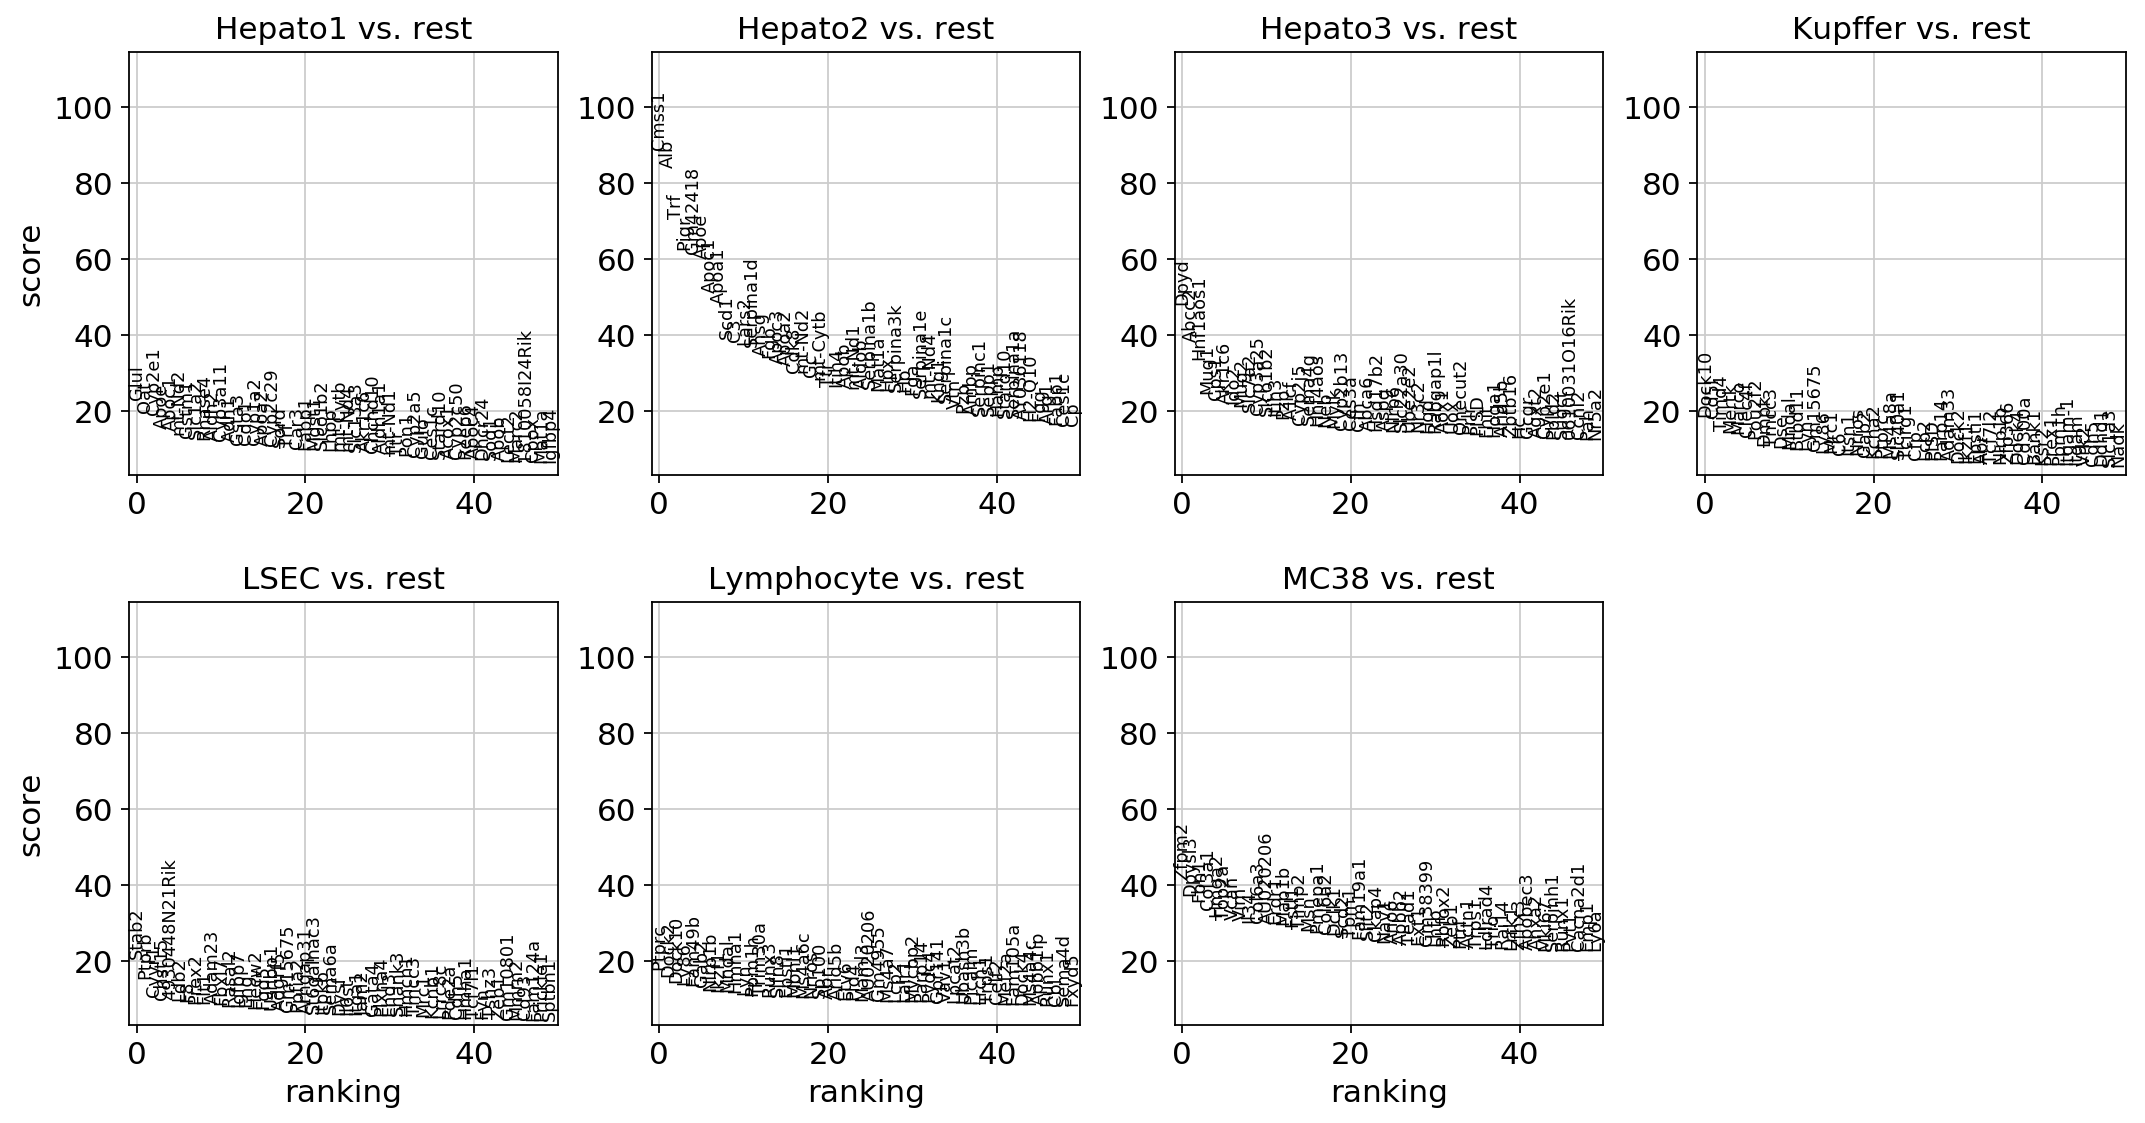

In [4]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata_mouse,use_raw=False,groupby='celltype')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(adata_mouse,n_genes=50)
sc.settings.verbosity = 3

In [48]:
genes = dict()
gene_array = np.array([list(i) for i in adata_mouse.uns['rank_genes_groups']['names']])
for i in range(gene_array.shape[1]):
    if i == 0:
        genes['hep1'] = list(gene_array[:20,i])
    elif i == 2:
        genes['hep3'] = list(gene_array[:20,i])
    elif i == 4:
        genes['hep3'] = list(gene_array[:20,i])
    elif i == 1:
        genes['hep2'] = list(gene_array[:40,i])
    elif i == 6:
        genes['mc38'] = list(gene_array[:40,i])

In [50]:
with open('/myvol/data2/reg.genes.2.txt', 'wb') as file:
    pkl.dump(genes,file)

The above is looking at all of the clusters. However, after running the super-resolution pipeline up to a certain point, the genes that are specifically marking the hepatocyte subclusters are generally in the same area. The biggest determinant of spatial differentiation is just mc38 vs hepatocyte (generally), so I'm going to just use the genes that differentiate those. My guess is that when just comparing the two groups, we'll find a very large number of top genes for each of them, but after a certain point they may begin to overlap. I'm wondering at what point they overlap.

In [57]:
ctdict2 = dict()
ctdict2['MC38'] = [3, 4]
ctdict2['Other'] = [6, 7, 8]
ctdict2['Hepato'] = [0, 1, 2, 5]
adata_mouse.obs['celltype2'] = adata_mouse.obs['leiden']
for ct in ctdict2:
    for clust in ctdict2[ct]:
        adata_mouse.obs['celltype2'].replace(r'^%s$' % str(clust),ct,regex=True, inplace=True)
adata_mouse.obs['celltype2'] = adata_mouse.obs['celltype2'].astype('category')

In [58]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata_mouse,use_raw=False,groupby='celltype2',groups=['Hepato'],reference='MC38',n_genes=5000)
hep_array = np.array([list(i)[0] for i in adata_mouse.uns['rank_genes_groups']['names']])
sc.tl.rank_genes_groups(adata_mouse,use_raw=False,groupby='celltype2',groups=['MC38'],reference='Hepato',n_genes=5000)
mc38_array = np.array([list(i)[0] for i in adata_mouse.uns['rank_genes_groups']['names']])
warnings.filterwarnings('default')
sc.settings.verbosity = 3

In [59]:
step = 50
num_overlap = list()
for i in np.arange(0,5000 + step,step):
    num_overlap.append(len(np.intersect1d(hep_array[:i],mc38_array[:i]))/5000)

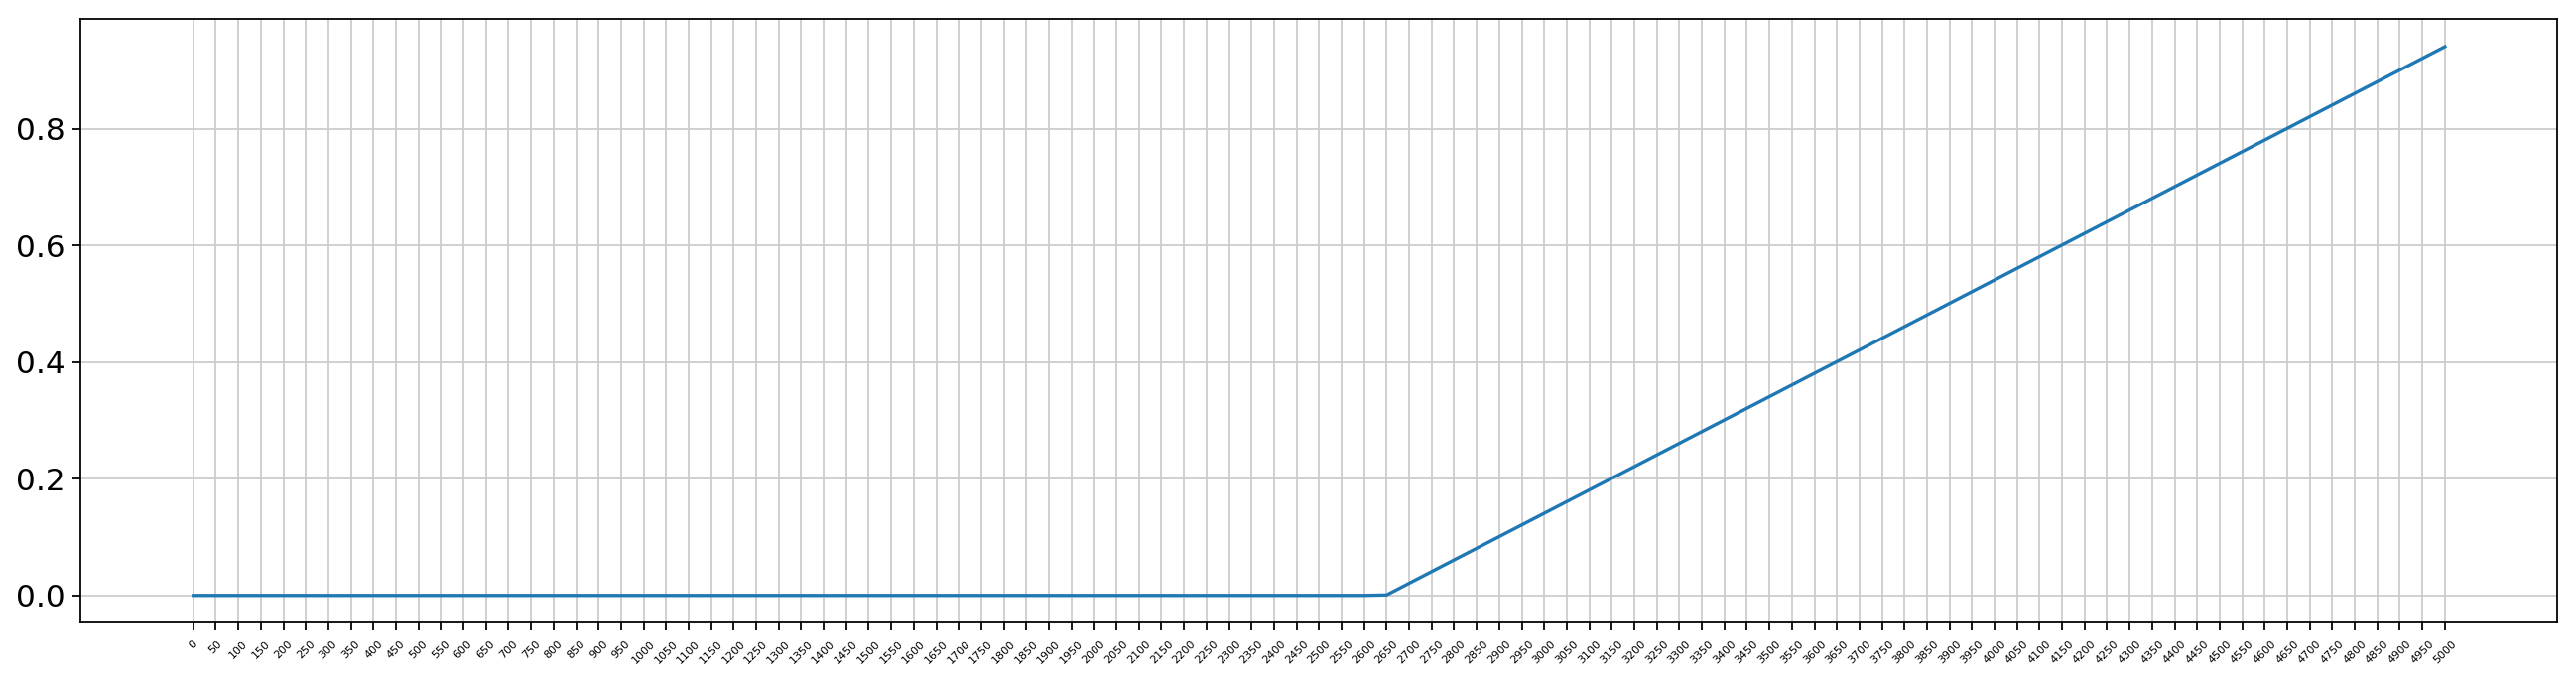

In [60]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,5000 + step,step),num_overlap);
plt.xticks(np.arange(0,5000 + step,step),size=5,rotation=45);

Yes, so even taking the top 2500 genes from each, there's still no overlap. Not to say all those 2500 are relevant and spatially distinct. I think I'll try with the top 200 from each right now, and then we can start taking more if necessary.

In [64]:
genes = dict()
genes['hep'] = hep_array[:200]
genes['mc38'] = mc38_array[:200]

In [65]:
with open('/myvol/data2/reg.genes.2.txt', 'wb') as file:
    pkl.dump(genes,file)